In [1]:
# Imports
from IPython.display import HTML
import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

winnie.utils.setup_jupyter_display()

### Input data:

The code assumes your data were processed through the imagetools align_frames step from SpaceKLIP, such that the position of the star is the same in all images. I'd also strongly recommend coadding your integrations for each exposure before proceeding. The code will do this anyway, but is much less careful about updating header info. For a SpaceKLIP imagetools object called ImageTools, this is just:

> ImageTools.coadd_frames(nframes=None, types=['SCI', 'SCI_BG', 'REF', 'REF_BG'], subdir='coadded')

In [2]:
# Prep the SpaceRDI object:
distance = 9.714 # Distance to your target in parsecs

base_dir = './aumic_rdi_example/'
input_dir = f'{base_dir}coadded/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
# There's quite a few options here. Check the docstring for more info!
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

In [3]:
# Load the 0th concatenation (F356W for the example case). 
wdb.load_concat(0)

# Full concatenation strings can be used instead (the keys for Database.obs)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [4]:
# Run RDI using the default settings

rdi_reduc = wdb.run_rdi(save_products=True)

[spaceKLIP.database:WARNING]   --> Could not find KL mode in header, assuming default value of 50


The run_rdi method returns a SpaceReduction object, which has the following properties:

    rdi_reduc.im: the derotated and roll-averaged final PSF-subtracted image (2D array)

    rdi_reduc.err: the propagated uncertainty maps based on the ERR fits extensions (2D array)

    rdi_reduc.rolls: the derotated and PSF-subtracted individual rolls (3D array)

    rdi_reduc.err_rolls: the propagated uncertainty maps for rdi_reduc.rolls (3D array)

    rdi_reduc.extent: the stellocentric image extent in arcsec for use with matplotlib

In [5]:
# You can convert the output to a more familiar HDUList if you prefer:
hdul = rdi_reduc.to_hdulist()
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     348   ()      
  1  SCI           1 ImageHDU       101   (430, 429)   float32   
  2  ERR           1 ImageHDU       101   (430, 429)   float64   
  3  SCI_ROLL1     1 ImageHDU       101   (430, 429)   float32   
  4  ERR_ROLL1     1 ImageHDU       101   (430, 429)   float64   
  5  SCI_ROLL2     1 ImageHDU       101   (430, 429)   float32   
  6  ERR_ROLL2     1 ImageHDU       101   (430, 429)   float64   


You can load a previous SpaceReduction object that you've saved in three ways:

By providing a) a SpaceRDI instance with a concat already loaded, and b) the output_ext used for the file:

`rdi_reduc = winnie.SpaceReduction(spacerdi=wdb, output_ext='rdi_psfsub')`

By providing a) a SpaceRDI instance with or without a concat already loaded, b) a concat to use, and c) the output_ext used for the file:

`rdi_reduc = winnie.SpaceReduction(spacerdi=wdb, concat=0, output_ext='rdi_psfsub')`

By providing the full path to the FITS file:

`rdi_reduc = winnie.SpaceReduction('./aumic_rdi_example/WinnieRDI/JWST_NIRCAM_NRCALONG_F356W_MASKA335R_SUB320A335R_rdi_psfsub.fits')`

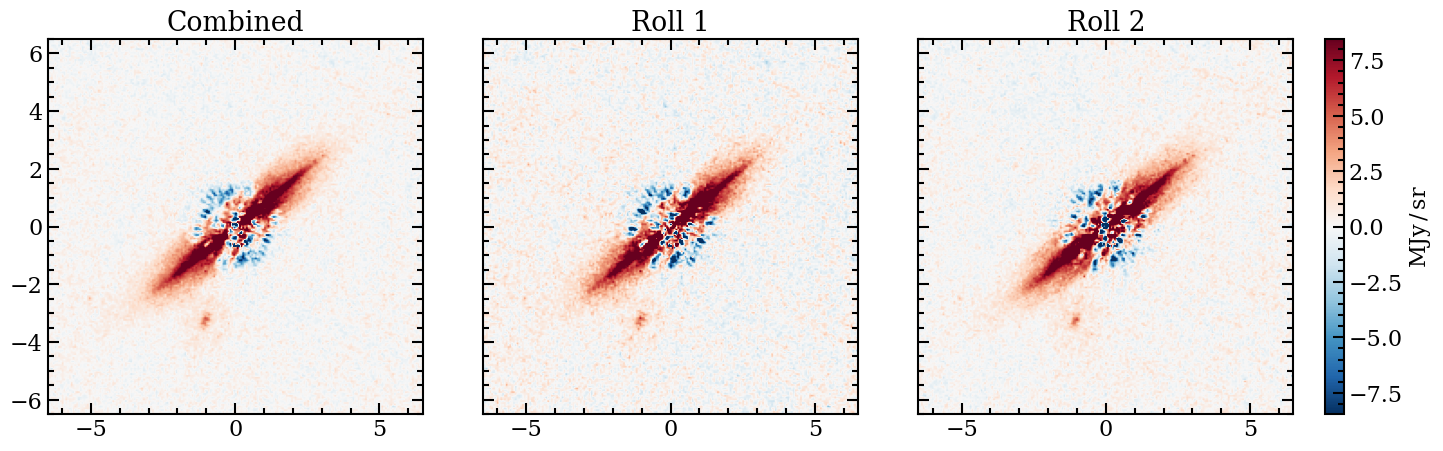

In [6]:
# Let's make a plot of the results, showing the combined image and each individual roll.

fig,axes,cbar = quick_implot([rdi_reduc.im, *rdi_reduc.rolls], show=False, clim_perc=99.5, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-6.5,6.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5), cbar_label=r'MJy$\,/\,$sr')

for i,label in enumerate(['Combined', 'Roll 1', 'Roll 2']):
    axes[i].set_title(label)
    
plt.show()

Let's try running a different variant of RDI: RDI with high-pass filtered coefficients (HPFRDI). 

For any of the presets methods (rdi_presets, hpfrdi_presets, and mcrdi_presets), the output_ext argument can be used to change the suffix for the file when saved. By default, standard RDI is 'rdi_psfsub', HPFRDI is 'hpfrdi_psfsub', and MCRDI is 'mcrdi_psfsub'. Of course, you can also change this simply by assigning a new output_ext property to your SpaceRDI instance.

Note: tutorial 3 covers what each of these presets is actually doing "under the hood". 

In [7]:
# Set the HPFRDI presets and then rerun run_rdi to get our result
wdb.hpfrdi_presets()

hpfrdi_reduc = wdb.run_rdi(save_products=True)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x153379440>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


[spaceKLIP.database:WARNING]   --> Could not find KL mode in header, assuming default value of 50


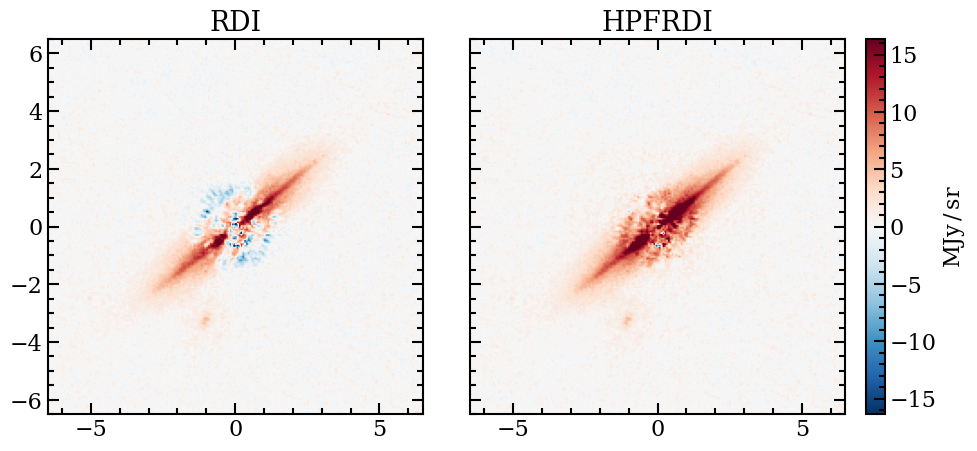

In [8]:
# Plot the comparison:

fig,axes,cbar = quick_implot([rdi_reduc.im, hpfrdi_reduc.im], show=False, clim_perc=99.9, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-6.5,6.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5), cbar_label=r'MJy$\,/\,$sr')

for i,label in enumerate(['RDI', 'HPFRDI']):
    axes[i].set_title(label)
    
plt.show()

Running the same procedures on the 2nd concatenation (F444W)

In [9]:
wdb.load_concat(1)

wdb.rdi_presets() # This is superfluous here, but included for reference — this just resets your RDI settings to the defaults
rdi_reduc = wdb.run_rdi(save_products=True)

wdb.hpfrdi_presets()
hpfrdi_reduc = wdb.run_rdi(save_products=True)

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


[spaceKLIP.database:WARNING]   --> Could not find KL mode in header, assuming default value of 50


JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x153379440>
'opt_smoothing_kwargs': {'filtersize': 1.197928007385561}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


[spaceKLIP.database:WARNING]   --> Could not find KL mode in header, assuming default value of 50


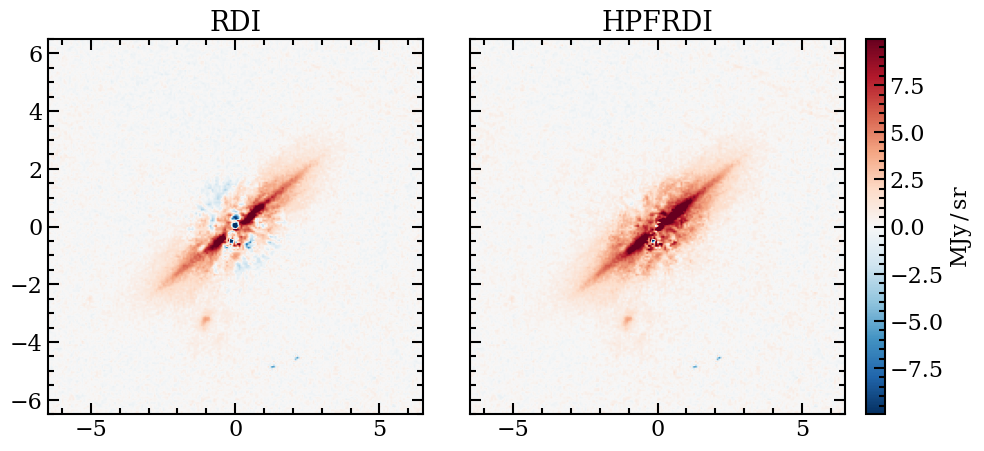

In [10]:
# Plot the comparison:
fig,axes,cbar = quick_implot([rdi_reduc.im, hpfrdi_reduc.im], show=False, clim_perc=99.9, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-6.5,6.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5), cbar_label=r'MJy$\,/\,$sr')

for i,label in enumerate(['RDI', 'HPFRDI']):
    axes[i].set_title(label)
    
plt.show()